In [29]:
import sys
sys.path.append("../python")

import json
import h5py
import numpy as np
import arviz as az
import compute_costs
import evaluations
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import math
from prettytable import PrettyTable

from matplotlib.colors import ListedColormap
cmap_blue = ListedColormap(["white", "lightsteelblue", "cornflowerblue", "royalblue", "blue", "navy"])
cmap = ListedColormap(["white", "darkorange", "gold", "navy", "steelblue", "yellowgreen"])
cmap_light = ListedColormap(["white", "bisque", "gold", "lavender", "aliceblue", "honeydew"])
cmap_gray = ListedColormap(["lightgray"])

In [30]:
parameters_paths = [
    "../configs/test_mlda/mh_1.json",
    "../configs/test_01/mh_2.json",
    "../configs/test_01/mlda_1.json",
    "../configs/test_01/mlda_2.json",
    "../configs/test_01/mlda_3.json",
    "../configs/test_01/mlda_8.json"
]

file = open(parameters_paths[0])
config = json.load(file)
file.close()

result_paths = [
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mh_1",
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mh_2",
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mlda_1",
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mlda_2",
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mlda_3",
    "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mlda_8"
] 

settings = ["MH (high prop. variance)", "MH (small prop. variance)", "MLDA 1", "MLDA 2", "MLDA 3", "MLDA 8"]

num_samples = [330000, 330000, 100000, 100000, 100000, 100000]
num_burn_in = [30000, 30000, 10000, 10000, 10000, 10000]

# load samples
number_of_chains = config["Setup"]["Chains"]
number_of_experiments = len(result_paths)

samples = []
for path in result_paths:
    result_list = []
    for c in range(number_of_chains):
        fin = h5py.File(path + "_" + str(c) + ".h5")
        result_list.append(np.array(fin['/samples']))
    fin.close()
    samples.append(result_list)

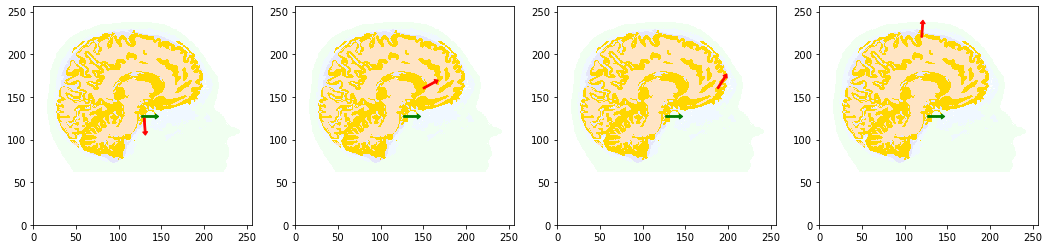

In [31]:
mesh = np.load(config[config["Sampling"]["Levels"][0]]["Mesh"])

elements = mesh['elements']
nodes = mesh['nodes']
labels = mesh['labels']
gray_probs = mesh['gray_probs']

n = int(math.sqrt(len(elements)))
z = np.ndarray((n,n),float)

for k in range(n):
    for j in range(n):
        z[j,k] = labels[k+n*j]

fig, axis = plt.subplots(1,4,figsize=(18,6))
start = [127,127,0]

for c in range(number_of_chains):
    point = (config["ModelConfig"]["Dipoles"][c][0],config["ModelConfig"]["Dipoles"][c][1],config["ModelConfig"]["Dipoles"][c][2])

    axis[c].pcolormesh(z,cmap=cmap_light)
    axis[c].set_aspect(1)

    evaluations.draw_dipole(axis[c], start, "green", 20)
    evaluations.draw_dipole(axis[c], point, "red",20)

plt.show()

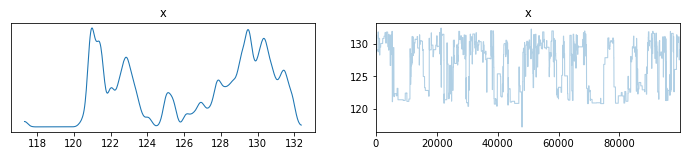

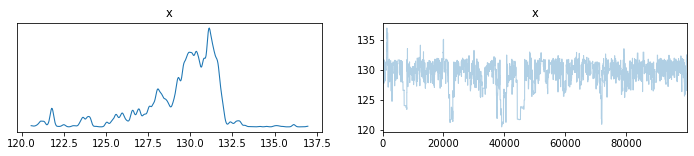

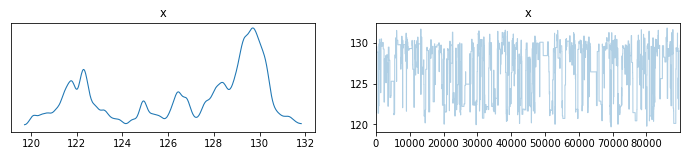

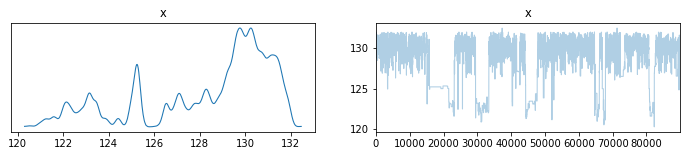

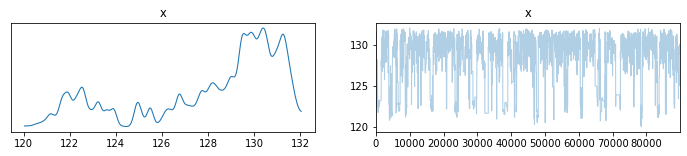

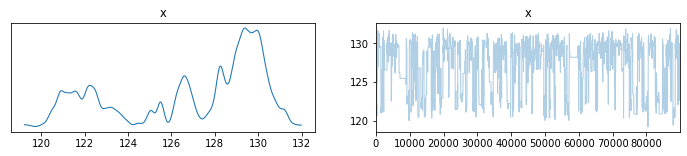

In [32]:
chain = 0
parameter = 0

for i in range(number_of_experiments):
    s = samples[i][chain][parameter][0:100000]
    p = az.plot_trace(s)
    
    

In [33]:
costs = np.zeros(number_of_experiments)
for i in range(number_of_experiments):
    costs[i] = evaluations.costs_per_sample(parameters_paths[i])

Dipole:
Dipole[position: [130 125] moment: [0.0707372 -0.997495]]
volume_conductor.time_creating_grid = 0.512466
volume_conductor.time_reordering_labels = 0.0046228
volume_conductor.time = 0.517091
time_element_neighborhood_map 0.0339244 s
degree = 1
element_type = hexahedron
Dipole[position: [130 125] moment: [0.0707372 -0.997495]]
sigma = 0.46864603702704066
{'Level3_V': {0: array([ 4.29684678,  3.80019397,  5.00788786,  2.23173785,  2.1916233 ,
        6.85250233,  6.2864223 ,  0.5573356 ,  6.61422506,  0.66830683,
        8.28873198, -0.05400869,  1.11143579, 10.05823371, -0.95990589,
       -1.37323444, -2.20170742, -1.28251414, -2.24957841, -3.12178533,
       -3.85807284, -4.17936424, -3.85515068, -4.52036698, -3.74170585,
       -4.75272747, -4.19935681, -4.49696823, -3.52009725, -3.70537772,
       -4.3521182 , -1.09745503, -0.44321816, -0.43070739,  0.48592143,
        0.17617692])}}
volume_conductor.time_creating_grid = 0.281849
{'solver.reduction': 1e-10, 'source_model': {'

In [34]:
ess = np.zeros((number_of_experiments,number_of_chains))
samples_per_es = np.zeros((number_of_experiments,number_of_chains))
costs_per_es = np.zeros((number_of_experiments,number_of_chains))

for i in range(number_of_experiments):
    for j in range(number_of_chains):
        chain = samples[i][j]
        ess[i,j] = np.around(min(az.ess(chain[0]),az.ess(chain[1]),az.ess(chain[2])),2)
        samples_per_es[i,j] =  np.around((num_samples[i]-num_burn_in[i])/ess[i,j],2)
        costs_per_es[i,j] = np.around(costs[i]/ess[i,j],2)

In [35]:
t = PrettyTable(['Algorithm', 'ESS', 'Samples per ES', 'Costs per ES (s)'])

for j in range(number_of_chains):
    for i in range(number_of_experiments):
        t.add_row([settings[i],ess[i,j],samples_per_es[i,j],costs_per_es[i,j]])

print(t)

+---------------------------+---------+----------------+------------------+
|         Algorithm         |   ESS   | Samples per ES | Costs per ES (s) |
+---------------------------+---------+----------------+------------------+
|  MH (high prop. variance) |  197.39 |    1519.83     |       7.95       |
| MH (small prop. variance) |  218.51 |    1372.93     |       8.19       |
|           MLDA 1          |  171.44 |     524.97     |       8.19       |
|           MLDA 2          |  53.62  |    1678.48     |      44.21       |
|           MLDA 3          |  160.01 |     562.46     |      13.74       |
|           MLDA 8          |  102.0  |     882.35     |      26.19       |
|  MH (high prop. variance) | 1563.16 |     191.92     |       1.0        |
| MH (small prop. variance) | 3066.49 |     97.83      |       0.58       |
|           MLDA 1          |  291.46 |     308.79     |       4.82       |
|           MLDA 2          | 1569.85 |     57.33      |       1.51       |
|           